C:\Users\hp\AppData\Local\Temp\ipykernel_11192\3824801690.py:46: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


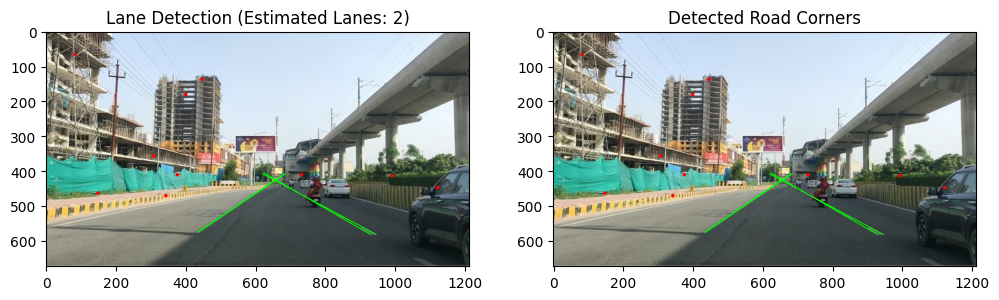

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

def detect_lanes(image):
    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    height, width = gray.shape
    mask = np.zeros_like(gray)
    roi_points = np.array([
        [(int(width * 0.1), height), (int(width * 0.9), height), 
         (int(width * 0.6), int(height * 0.6)), (int(width * 0.4), int(height * 0.6))]
    ], dtype=np.int32)
    
    cv2.fillPoly(mask, roi_points, 255)
    roi_edges = cv2.bitwise_and(edges, mask)

    lines = cv2.HoughLinesP(roi_edges, 1, np.pi/180, threshold=50, minLineLength=60, maxLineGap=100)

    lane_lines = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            slope = abs((y2 - y1) / (x2 - x1 + 1e-6)) 
            if 0.3 < slope < 3:  
                lane_lines.append((x1, y1, x2, y2))
                cv2.line(original, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Estimate Number of Lanes
    num_lanes = len(lane_lines) // 2  
    return original, num_lanes

def detect_corners(image):
    """Detect road corners using Shi-Tomasi method"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    
    # Detect corners
    corners = cv2.goodFeaturesToTrack(edges, maxCorners=10, qualityLevel=0.2, minDistance=30)
    
    if corners is not None:
        corners = np.int0(corners)
        for corner in corners:
            x, y = corner.ravel()
            cv2.circle(image, (x, y), 5, (0, 0, 255), -1)
    
    return image, corners

image_path = "road_image.jpg"  
image = cv2.imread(image_path)

image1, num_lanes = detect_lanes(image)
image2, road_corners = detect_corners(image1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title(f"Lane Detection (Estimated Lanes: {num_lanes})")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title("Detected Road Corners")

plt.show()


In [11]:
def non_max_suppression(boxes, overlap_thresh=0.3):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    x1, y1, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x2, y2 = x1 + w, y1 + h

    areas = w * h
    indices = np.argsort(y2) 

    keep = []
    while len(indices) > 0:
        i = indices[-1] 
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[indices[:-1]])
        yy1 = np.maximum(y1[i], y1[indices[:-1]])
        xx2 = np.minimum(x2[i], x2[indices[:-1]])
        yy2 = np.minimum(y2[i], y2[indices[:-1]])

        w_overlap = np.maximum(0, xx2 - xx1)
        h_overlap = np.maximum(0, yy2 - yy1)
        overlap = (w_overlap * h_overlap) / areas[indices[:-1]]

        indices = indices[np.where(overlap < overlap_thresh)] 

    return boxes[keep].tolist()

def detect_billboards(scene_image_path, templates):
    """Detect billboards using template matching and apply NMS to remove duplicate detections"""
    scene_img = cv2.imread(scene_image_path)
    gray_scene = cv2.cvtColor(scene_img, cv2.COLOR_BGR2GRAY)

    detected_boxes = []

    for template_path in templates:
        template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
        w, h = template.shape[::-1]

        result = cv2.matchTemplate(gray_scene, template, cv2.TM_CCOEFF_NORMED)
        threshold = 0.7  
        loc = np.where(result >= threshold)

        for pt in zip(*loc[::-1]):
            detected_boxes.append((pt[0], pt[1], w, h))

    filtered_boxes = non_max_suppression(detected_boxes, overlap_thresh=0.4)

    for (x, y, w, h) in filtered_boxes:
        cv2.rectangle(scene_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv2.imshow('Filtered Billboards', scene_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return filtered_boxes

scene_image_path = 'test.jpg'
templates = ['billboard1.jpg', 'billboard2.jpg']

detected = detect_billboards(scene_image_path, templates)
print("Filtered Billboards:", detected)


Filtered Billboards: [[215, 174, 39, 22], [269, 151, 61, 30]]


In [12]:
def classify_position(billboards, image_shape):
    """ Determine whether billboards are on LHS, RHS, or Overhead """
    positions = []
    mid_x = image_shape[1] // 2

    for (x1, y1, x2, y2) in billboards:
        if x2 < mid_x:
            positions.append("LHS")
        elif x1 > mid_x:
            positions.append("RHS")
        else:
            positions.append("Overhead")

    return positions

In [13]:
def detect_occlusion(billboards, image):
    """ Detect occlusion percentage of billboards """
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    for (x1, y1, x2, y2) in billboards:
        mask[y1:y2, x1:x2] = 255

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    occlusion_percentages = []

    for i, (x1, y1, x2, y2) in enumerate(billboards):
        billboard_area = (x2 - x1) * (y2 - y1)
        occluded_area = cv2.contourArea(contours[i]) if i < len(contours) else 0
        occlusion_percentage = min((occluded_area / billboard_area) * 100, 100)  
        occlusion_percentages.append(occlusion_percentage)

    return occlusion_percentages

In [14]:
def detect_clutter(billboards):
    """ Detect billboards that are too close to each other using centroid distances """
    clutter_pairs = []
    threshold_distance = 50  
    centroids = [( (x1 + x2) // 2, (y1 + y2) // 2 ) for (x1, y1, x2, y2) in billboards]
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            distance = np.linalg.norm(np.array(centroids[i]) - np.array(centroids[j]))
            if distance < threshold_distance:
                clutter_pairs.append((billboards[i], billboards[j]))

    return clutter_pairs

In [15]:
def compute_billboard_metrics(billboards, road_corners, road_level_y):
    """ Compute billboard width, height, elevation, setback distance, and angle """
    metrics = []

    for (x1, y1, x2, y2) in billboards:
        width = x2 - x1
        height = y2 - y1
        elevation = road_level_y - y2  
        setback_distance = min(
            [np.linalg.norm(np.array([x1, y1]) - np.array(corner)) for corner in road_corners]
        ) if len(road_corners) > 0 else 0

        aspect_ratio = round(width / height, 2) if height > 0 else 0
        metrics.append((width, height, elevation, setback_distance, aspect_ratio))
    return metrics

In [16]:
def estimate_distance(billboards, focal_length=500, actual_height=3.0):
    """ Estimate distance of billboards from camera """
    distances = []

    for (x1, y1, x2, y2) in billboards:
        perceived_height = y2 - y1
        distance = (actual_height * focal_length) / perceived_height if perceived_height > 0 else float('inf')
        distances.append(distance)

    return distances

In [17]:
# Classify Billboard Positions & Compute Metrics
positions = classify_position(detected, image.shape)
occlusions = detect_occlusion(detected, image)
cluttered_pairs = detect_clutter(detected)
distances = estimate_distance(detected)

# Compute Billboard Metrics
road_level_y = image.shape[0] - 10  
billboard_metrics = compute_billboard_metrics(detected, road_corners, road_level_y)


In [18]:
# Print Results
for i, (w, h, e, d, a) in enumerate(billboard_metrics):
    print(f"Billboard {i+1}: Position={positions[i]}, Width={w}px, Height={h}px, "
          f"Elevation={e}px, Setback Distance={d:.2f}px, Aspect Ratio={a}, "
          f"Occlusion={occlusions[i]:.2f}%, Distance={distances[i]:.2f}m")

if cluttered_pairs:
    print(f"⚠️ Clutter Detected: {len(cluttered_pairs)} pairs of billboards are too close.")


Billboard 1: Position=LHS, Width=-176px, Height=-152px, Elevation=641px, Setback Distance=169.92px, Aspect Ratio=0, Occlusion=0.00%, Distance=infm
Billboard 2: Position=LHS, Width=-208px, Height=-121px, Elevation=633px, Setback Distance=134.39px, Aspect Ratio=0, Occlusion=0.00%, Distance=infm
⚠️ Clutter Detected: 1 pairs of billboards are too close.
